# Выбор локации для скважины.

## Введение

**Описание проекта**

Для добывающей компании "ГлавРосГосНефтьПромСтройСибЭлектроСнаб" нужно решить, где бурить новую скважину.

Предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Необходимо построить модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализировать возможную прибыль и риски техникой Bootstrap.

Шаги для выбора локации:

- В избранном регионе собирают характеристики для скважин: качество нефти и объём её запасов;
- Строят модель для предсказания объёма запасов в новых скважинах;
- Выбирают скважины с самыми высокими оценками значений;
- Определяют регион с максимальной суммарной прибылью отобранных скважин.

**Условия задачи:**

Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
Бюджет на разработку скважин в регионе — 10 млрд рублей.
При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирать регион с наибольшей средней прибылью.

## Описание данных

**Признаки:**
- `id` — уникальный идентификатор месторождения;
- `f0`, `f1`, `f2` — три признака точек (неважно, что они означают, но сами признаки значимы);

**Целевой признак:**
- `product` — объём запасов в месторождении (тыс. баррелей).

## Загрузка и подготовка данных

### Импорт используемых библиотек и методов

In [1]:
# импортируем библиотеки и необходимые методы из других библиотек
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

### Настройка стилей и форматов вывода

In [2]:
# настроим точность вывода до 2-х десятичных знаков и разделители тысяч (групп разрядов) для больших чисел
pd.set_option('display.float_format', '{:,.2f}'.format)

# установим графическую тему для графиков и гистограмм
plt.style.use('seaborn')

# настроим местоположение и размер шрифта для легенды и названий графиков и гистограмм
rcParams['legend.loc'] = 'upper left'
rcParams['legend.fontsize'] = 14
rcParams['axes.titlesize'] = 18

### Объявление глобальных переменных

In [3]:
# случайное состояние для создания псевдослучайных последовательностей
MY_SEED = 1123581321

### Чтение данных

In [4]:
# читаем данные в датафреймы с локального ПК, а если не получится, то из интернета
try:
    df0 = pd.read_csv('./datasets/geo_data_0.csv', sep=',')
    df1 = pd.read_csv('./datasets/geo_data_1.csv', sep=',')
    df2 = pd.read_csv('./datasets/geo_data_2.csv', sep=',')
except:
    print('ОШИБКА: Данные не были прочитаны, читаем из интернета!')
    df0 = pd.read_csv('***', sep=',')
    df1 = pd.read_csv('***', sep=',')
    df2 = pd.read_csv('***', sep=',')

### Предобработка данных

#### Общая информацию о данных

Создадим функцию для вывода общей информации о датафрейме:
- Информацию о структуре и типе данных;
- Описание и основные характеристики данных;
- Несколько случайных строк данных;
- Гистограммы распределения;
- Тепловую карту корреляции признаков;
- Количество явных дубликатов.

In [5]:
# -----------------------------------------------------------------------------------------
# функция вывода общей информации о датафрейме
# -----------------------------------------------------------------------------------------
def first_look(df):
    display(df.info())
    display(df.describe())
    display(df.sample(5))
    df.hist(bins=30, figsize=(15, 10))
    plt.figure(figsize=(15, 10))
    plt.title('Корреляция признаков', weight = 'bold')
    sns.heatmap(df.corr(method='spearman'), annot = True, cmap='BuGn')
    plt.show()
    print('Количество дубликатов в данных:', df.duplicated().sum())
    print(f'Количество столбцов: {df.shape[1]}, число записей: {df.shape[0]}')
    return

Выведем информацио о данных последовательно вызывая функцию `first_look()` для каждого датасета.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,f0,f1,f2,product
count,"100,000.00","100,000.00","100,000.00","100,000.00"
mean,0.50,0.25,2.50,92.50
std,0.87,0.50,3.25,44.29
min,-1.41,-0.85,-12.09,0.00
25%,-0.07,-0.20,0.29,56.50
50%,0.50,0.25,2.52,91.85
75%,1.07,0.70,4.72,128.56
max,2.36,1.34,16.00,185.36


,id,f0,f1,f2,product
91445,MpZCp,0.96,0.51,1.64,23.02
98827,BZr7B,1.66,-0.52,3.06,79.38
83698,TpbQj,0.03,0.30,-0.98,70.49
54327,vg2Oj,0.84,-0.51,2.04,123.17
44678,FdePp,1.83,-0.20,-3.26,55.68


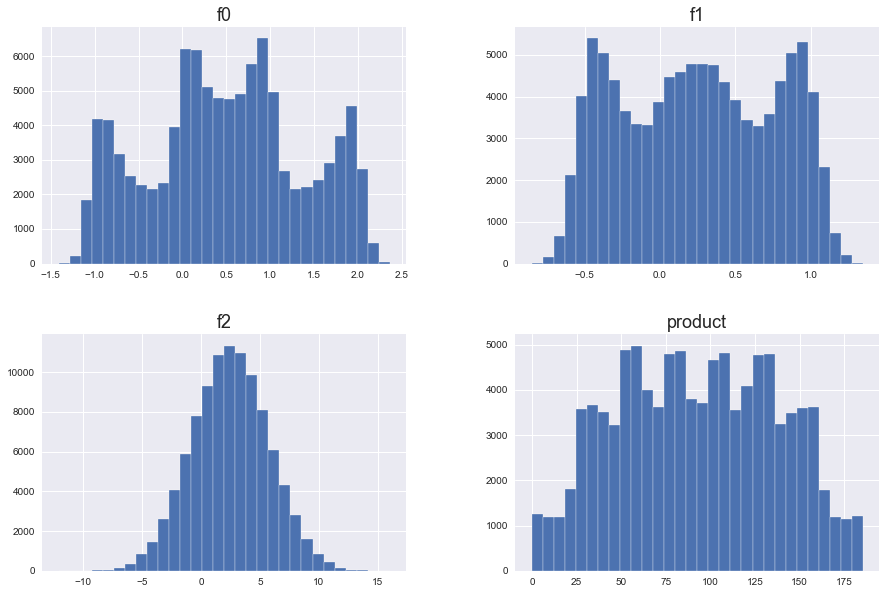

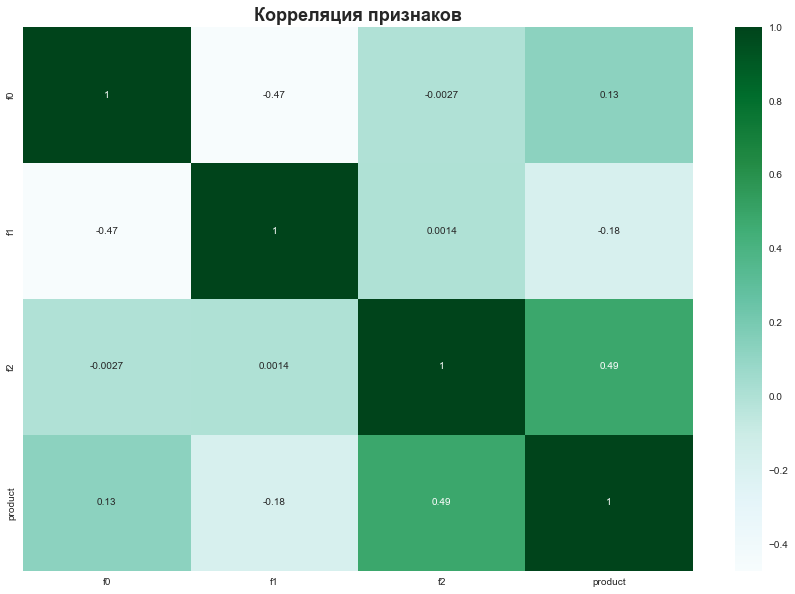

Количество дубликатов в данных: 0
Количество столбцов: 5, число записей: 100000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,f0,f1,f2,product
count,"100,000.00","100,000.00","100,000.00","100,000.00"
mean,1.14,-4.80,2.49,68.83
std,8.97,5.12,1.70,45.94
min,-31.61,-26.36,-0.02,0.00
25%,-6.30,-8.27,1.00,26.95
50%,1.15,-4.81,2.01,57.09
75%,8.62,-1.33,4.00,107.81
max,29.42,18.73,5.02,137.95


,id,f0,f1,f2,product
30936,3kssT,-17.18,-7.75,5.00,137.95
65102,xUS2n,5.87,4.86,5.00,134.77
61183,4zViF,3.80,-0.89,1.99,53.91
20406,aygVo,5.35,-3.12,2.00,57.09
57804,N0X8T,16.11,-3.44,1.00,26.95


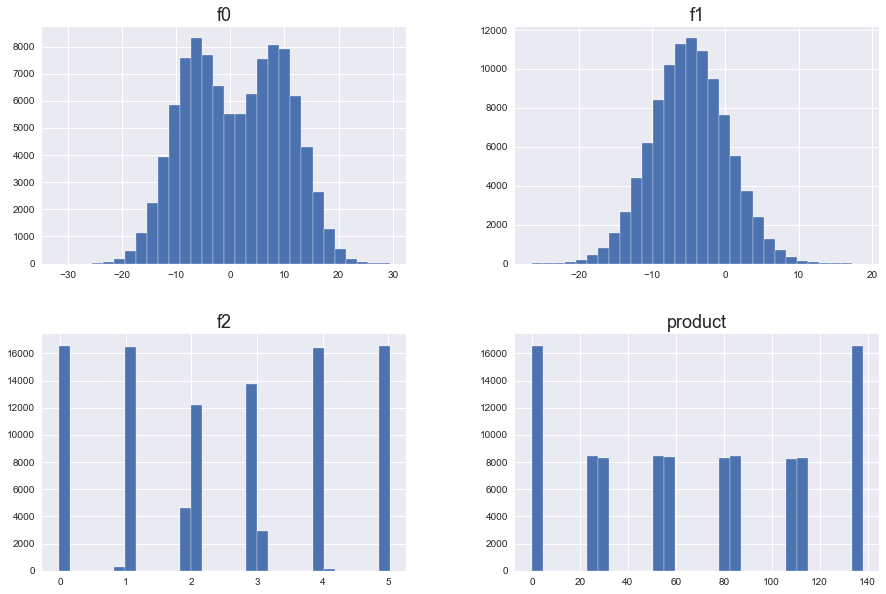

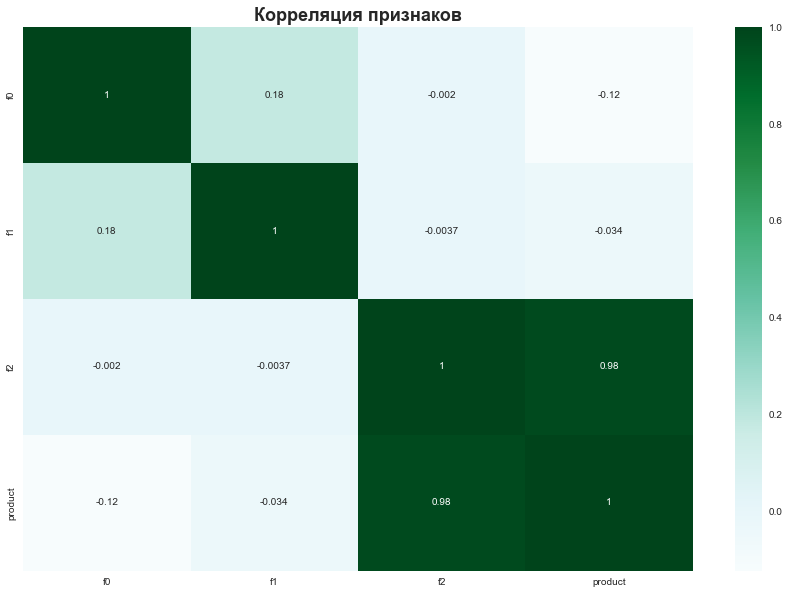

Количество дубликатов в данных: 0
Количество столбцов: 5, число записей: 100000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,f0,f1,f2,product
count,"100,000.00","100,000.00","100,000.00","100,000.00"
mean,0.00,-0.00,2.50,95.00
std,1.73,1.73,3.47,44.75
min,-8.76,-7.08,-11.97,0.00
25%,-1.16,-1.17,0.13,59.45
50%,0.01,-0.01,2.48,94.93
75%,1.16,1.16,4.86,130.60
max,7.24,7.84,16.74,190.03


,id,f0,f1,f2,product
77796,geB6E,-1.81,1.03,3.26,143.77
94870,dXkYX,0.82,-1.78,1.76,6.79
47035,XUXRB,-1.08,-3.30,-2.32,76.62
20527,qYjPi,0.02,-4.54,2.56,155.88
54476,Y8tsS,1.64,-0.09,4.05,122.11


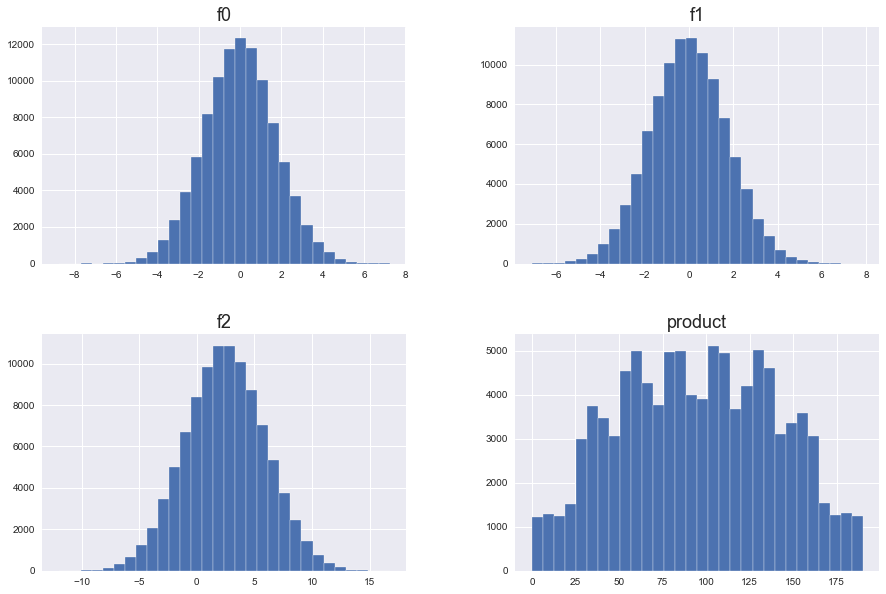

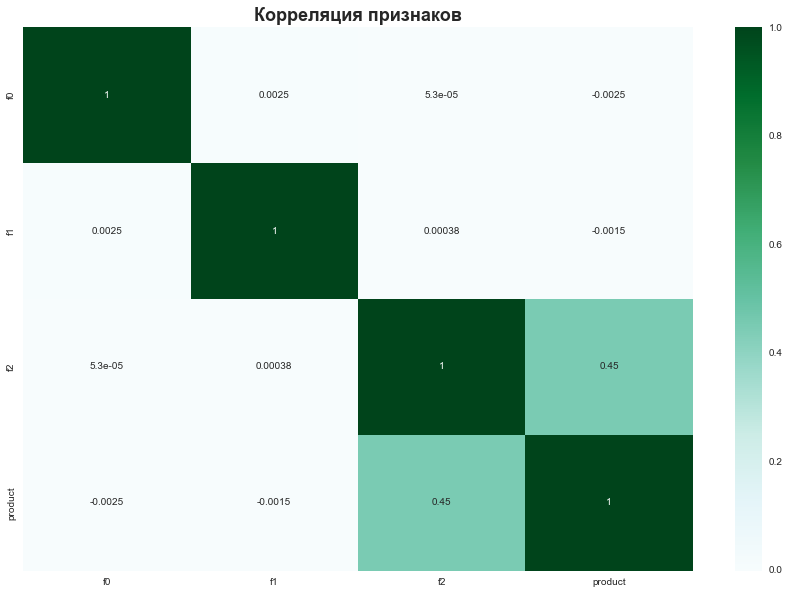

Количество дубликатов в данных: 0
Количество столбцов: 5, число записей: 100000


In [6]:
first_look(df0)
first_look(df1)
first_look(df2)

В таблицах отсутствуют пропуски. Все данные, кроме колонки `id` имеют численное значение. Столбец `id` не несет информации для обучения модели. Для региона 1, признак `f2` имеет высокую корреляцию с целевым признаком.

## Обучение и проверка модели

Удалим столбец `id` из данных по всем регионам.

In [7]:
df0.drop(['id'], axis='columns', inplace=True)
df1.drop(['id'], axis='columns', inplace=True)
df2.drop(['id'], axis='columns', inplace=True)

Выделим из данных целевой признак и разобьём данные на обучающую и валидационную выборки.

In [8]:
# выделим целевой признак
target_0 = df0['product']
target_1 = df1['product']
target_2 = df2['product']

# создадим признаки для модели
features_0 = df0.drop('product', axis=1)
features_1 = df1.drop('product', axis=1)
features_2 = df2.drop('product', axis=1)

# отделим обучающий (train) и проверочный (valid) датасеты
features_train_0, features_valid_0, target_train_0, target_valid_0 = train_test_split(features_0, target_0, test_size=0.25, random_state=MY_SEED)
features_train_1, features_valid_1, target_train_1, target_valid_1 = train_test_split(features_1, target_1, test_size=0.25, random_state=MY_SEED)
features_train_2, features_valid_2, target_train_2, target_valid_2 = train_test_split(features_2, target_2, test_size=0.25, random_state=MY_SEED)

# выведем сведения о разбивке данных
print(f'Данные разбиты в соотношении: '
      f'{len(features_train_0) / len(features_0):.2f}:'
      f'{len(features_valid_0) / len(features_0):.2f}')

Данные разбиты в соотношении: 0.75:0.25


Маcштабируем признаки, используя один из методов масштабирования — стандартизации данных.
В *sklearn* есть отдельная структура для стандартизации данных — *StandardScaler()*.

In [9]:
scaler = StandardScaler()

# масштабируем обучающие выборки
features_train_0 = scaler.fit_transform(features_train_0)
features_train_1 = scaler.fit_transform(features_train_1)
features_train_2 = scaler.fit_transform(features_train_2)

# масштабируем проверочные выборки
features_valid_0 = scaler.fit_transform(features_valid_0)
features_valid_1 = scaler.fit_transform(features_valid_1)
features_valid_2 = scaler.fit_transform(features_valid_2)

Данная задача относиться к задачам регрессии. Обучим модель *'Линейная регрессия'* для каждого региона.
Напишем функцию *oil_reserves()*, которая обучит модель, сделает предсказание, выведет средний запас нефти по региону, рассчитает *RMSE* модели и вернёт массив предсказаний модели по региону.

In [10]:
# -----------------------------------------------------------------------------------------
# функция расчёта запасов нефти и RMSE по региону
# -----------------------------------------------------------------------------------------
def oil_reserves(features_train, target_train, features_valid, target_valid):
    model = LinearRegression().fit(features_train, target_train)
    predicted = model.predict(features_valid)
    rmse = (mean_squared_error(target_valid, predicted)) ** 0.5
    print(f'Средний запас предсказанного сырья в регионе: {predicted.mean():.2f} тыс. баррелей')
    print(f'RMSE модели {rmse:.2f}')
    return predicted

Выведем данные по каждому региону.

In [11]:
print('Регион 0')
predicted_0 = oil_reserves(features_train_0, target_train_0, features_valid_0, target_valid_0)
print()

print('Регион 1')
predicted_1 = oil_reserves(features_train_1, target_train_1, features_valid_1, target_valid_1)
print()

print('Регион 2')
predicted_2 = oil_reserves(features_train_2, target_train_2, features_valid_2, target_valid_2)

Регион 0
Средний запас предсказанного сырья в регионе: 92.58 тыс. баррелей
RMSE модели 37.63

Регион 1
Средний запас предсказанного сырья в регионе: 69.00 тыс. баррелей
RMSE модели 1.12

Регион 2
Средний запас предсказанного сырья в регионе: 95.01 тыс. баррелей
RMSE модели 40.22


Лучшее значение метрики *RMSE* показала модель для региона №1 - `1.12`.

## Подготовка к расчёту прибыли

Рассчитаем минимальный средний объём сырья в месторождениях региона, достаточный для его безубыточной разработки. По условиям у нас есть следующие данные:

- При разведке региона исследуют 500 точек;
- Выбирают 200 лучших точек для разработки;
- Бюджет на разработку скважин в регионе — 10 млрд. рублей;
- Доход с каждой единицы продукта составляет 450 тыс. рублей.
- Количество *bootstrap* выборок - 1000;
- Доверительный интервал 95%.

In [12]:
# сбросим индексы целевого признака в валидационной выборке для каждого региона:
target_valid_0.reset_index(drop=True, inplace=True)
target_valid_1.reset_index(drop=True, inplace=True)
target_valid_2.reset_index(drop=True, inplace=True)

# переведем предсказания в валидационной выборке в pd.Series:
predicted_0 = pd.Series(predicted_0)
predicted_1 = pd.Series(predicted_1)
predicted_2 = pd.Series(predicted_2)

# сохраним все ключевые значения для расчётов в отдельных глобальных переменных
POINTS = 500                                # количество точек исследования
TOP_POINTS = 200                            # количество лучших точек для разработки
BUDGET = 10000000000                        # бюджет на разработку
PROFIT = 450000                             # доход
BOOTSTRAP_SAMPLES = 1000                    # количество bootstrap выборок
ALPHA = 0.05                                # альфа-квантиль
STATE = np.random.RandomState(MY_SEED)      # контейнер для генератора случайных чисел

zero_profit_value = BUDGET / (TOP_POINTS * PROFIT)
print (f'Достаточный объём сырья для безубыточной разработки новой скважины: {zero_profit_value:.2f} тыс. баррелей')

Достаточный объём сырья для безубыточной разработки новой скважины: 111.11 тыс. баррелей


Данное значение превышает средние значения запасов скважин во всех регионах.

Напишем функцию для расчёта прибыли по набору отобранных месторождений и предсказаний модели, которая принимает на вход истинные значения целевого признака, предсказания и количество скважин, возвращает общую прибыль в миллионах рублей.

In [13]:
# -----------------------------------------------------------------------------------------
# функция расчёта прибыли (в миллионах рублей)
# по набору отобранных месторождений и предсказаний модели
# -----------------------------------------------------------------------------------------
def revenue(target, probabilities, count):
    probs_sorted = probabilities.sort_values(ascending=False)
    # выбираем лучшие в количестве count штук
    selected = target[probs_sorted.index][:count]
    # считаем и возвращаем прибыль в миллионах рублей
    return (PROFIT * selected.sum() - BUDGET) / 1e6

Данные подготовлены для *Bootstrap* и статистического анализа.

## Расчёт прибыли и рисков

Посчитаем риски и прибыль для каждого региона.

Применим технику *Bootstrap* для 1000 выборок, чтобы найти распределение прибыли.
Найдём среднюю прибыль, 95%-й доверительный интервал и риск убытков. Убыток — это отрицательная прибыль.

Создадим функцию для подсчета результатов.

In [14]:
# -----------------------------------------------------------------------------------------
# функция расчёта средней прибыли техникой bootstrap,
# доверительного интервала и риска убытков по региону
# -----------------------------------------------------------------------------------------
def distribution_revenue(target, probabilities):

    values = []

    for _ in range(BOOTSTRAP_SAMPLES):
        target_subsample = target.sample(n=POINTS, replace=True, random_state=STATE)
        probs_subsample = probabilities[target_subsample.index]
        values.append(revenue(target_subsample, probs_subsample, TOP_POINTS))

    values = pd.Series(values)

    print(f'Средняя прибыль: {values.mean():.2f} млн.руб.')

    lower = values.quantile(ALPHA/2)
    upper = values.quantile(1-ALPHA/2)
    print(f'95%-й доверительный интервал: {lower:.2f} - {upper:.2f} млн.руб.')

    print(f'Риск получения убытков: {(values < 0).mean():.2%}')
    return

Выведем расчёты средней прибыли, доверительного интервала и риска убытков для каждого региона.

In [15]:
print('Регион 0')
distribution_revenue(target_valid_0, predicted_0)
print()
print('Регион 1')
distribution_revenue(target_valid_1, predicted_1)
print()
print('Регион 2')
distribution_revenue(target_valid_2, predicted_2)

Регион 0
Средняя прибыль: 423.95 млн.руб.
95%-й доверительный интервал: -52.21 - 933.25 млн.руб.
Риск получения убытков: 4.70%

Регион 1
Средняя прибыль: 483.74 млн.руб.
95%-й доверительный интервал: 60.37 - 902.24 млн.руб.
Риск получения убытков: 0.90%

Регион 2
Средняя прибыль: 381.83 млн.руб.
95%-й доверительный интервал: -201.03 - 940.73 млн.руб.
Риск получения убытков: 8.60%


## Выводы

В регионе 0 и регионе 2 достаточно высокий средний показатель запаса предсказанного сырья. Однако, значение *RMSE* для данных регионов также высоко (**37.63** и **40.22** соответственно). Это свидетельствует о неоднозначности показателя, неточности модели регрессии.
В регионе 1 средний показатель запаса предсказанного сырья составляет **69** тыс. баррелей (ниже остальных регионов). Однако значение *RMSE* в данном регионе также небольшое **1.12**. Это говорит о точности предсказаний и качестве построенной модели для данного региона.
Средние показатели предсказанного сырья для одной скважины ниже теоретически необходимых *111.11* тыс. баррелей.

При применении техники *bootstrap*:
Оценка средней прибыли максимальна для региона 1: **483.74** млн. рублей.
Только регион 1 прогнозирует прибыльную разработку по 95% доверительному интервалу.
Риск убытков для региона 1: **0.9%**.

Для остальных регионов риск получить убыток значительно выше.

**Исходя из этих расчётов, только регион 1 можно рекомендовать для добычи нефти.**

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: модели обучены и проверены
    - [x]  Данные корректно разбиты на обучающую и валидационную выборки
    - [x]  Модели обучены, предсказания сделаны
    - [x]  Предсказания и правильные ответы на валидационной выборке сохранены
    - [x]  На экране напечатаны результаты
    - [x]  Сделаны выводы
- [x]  Выполнен шаг 3: проведена подготовка к расчёту прибыли
    - [x]  Для всех ключевых значений созданы константы Python
    - [x]  Посчитано минимальное среднее количество продукта в месторождениях региона, достаточное для разработки
    - [x]  По предыдущему пункту сделаны выводы
    - [x]  Написана функция расчёта прибыли
- [x]  Выполнен шаг 4: посчитаны риски и прибыль
    - [x]  Проведена процедура *Bootstrap*
    - [x]  Все параметры бутстрепа соответствуют условию
    - [x]  Найдены все нужные величины
    - [x]  Предложен регион для разработки месторождения
    - [x]  Выбор региона обоснован